# [E-15]OCRModels

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras_ocr
import os
import io
import cv2 

from google.cloud import vision
from pytesseract import Output
from pytesseract import pytesseract as pt
from PIL import Image, ImageDraw
from glob import glob

## 검증용 데이터셋 준비

In [2]:
fold_path = os.getenv('HOME')+'/aiffel/ocr_python/car_plate/'
os.listdir(fold_path)

['car6.jpeg',
 'car2.jpeg',
 'car20.jpeg',
 'car15.jpeg',
 'car3.jpeg',
 'car9.jpeg',
 'car13.jpeg',
 'car5.jpeg',
 'car12.jpeg',
 'car19.jpeg',
 'car16.jpeg',
 'car8.jpeg',
 'car10.jpeg',
 'car18.jpeg',
 'car14.jpeg',
 'car7.jpeg',
 'car17.jpeg',
 'car1.jpeg',
 'car11.jpeg',
 'car4.jpeg']

In [5]:
image_path = glob(fold_path+'*.jpeg')
image_path

['/aiffel/aiffel/ocr_python/car_plate/car6.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car2.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car20.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car15.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car3.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car9.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car13.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car5.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car12.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car19.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car16.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car8.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car10.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car18.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car14.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car7.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car17.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car1.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/car11.jpeg',
 '/aiffel/aiffel/ocr_python/car_plate/c

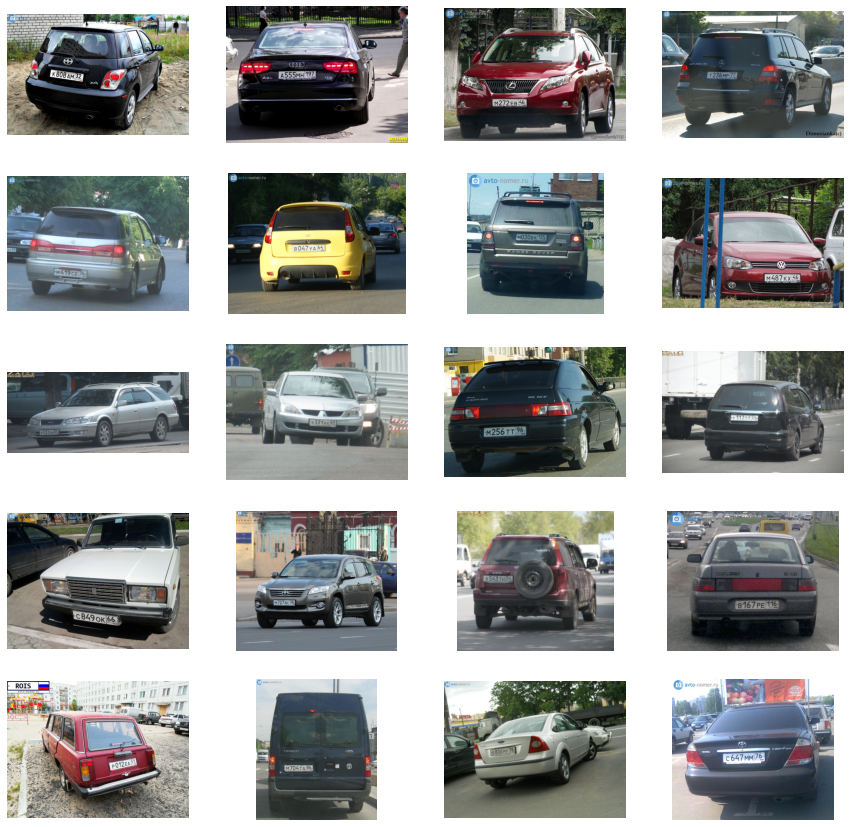

In [6]:
plt.figure(figsize=(15, 15))

for idx, image in enumerate(image_path):
    plt.subplot(5, 4, idx+1)
    im = img.imread(image)
    plt.imshow(im)
    plt.axis('off')

## OCR API

In [7]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [8]:
def detect_text(path):
    """Detects text in the file"""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    s = os.path.splitext(path)
    s = os.path.split(s[0])
    name = s[1]
    
    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [16]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

ocr_img = []
ocr_dict = {}
# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+'/aiffel/ocr_python/car_plate/car6.jpeg'


# # 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for path in image_path:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'red')
    ocr_img.append(image)

E0306 12:58:47.653205975     492 ev_epollex_linux.cc:1368]   pollset_set_add_fd: {"created":"@1646571527.653153687","description":"pollset_set_add_fd","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1646571527.653152606","description":"pollable_add_fd","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1646571527.653150391","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":634,"os_error":"Bad file descriptor","syscall":"epoll_ctl"}]}]}
E0306 12:58:47.653271472     492 ev_epollex_linux.cc:515]    Error shutting down fd 69. errno: 9
-rw-r--r-- 1 root root 2330 Feb 24 08:07 /aiffel/aiffel/ocr_python/my_google_api_key.json


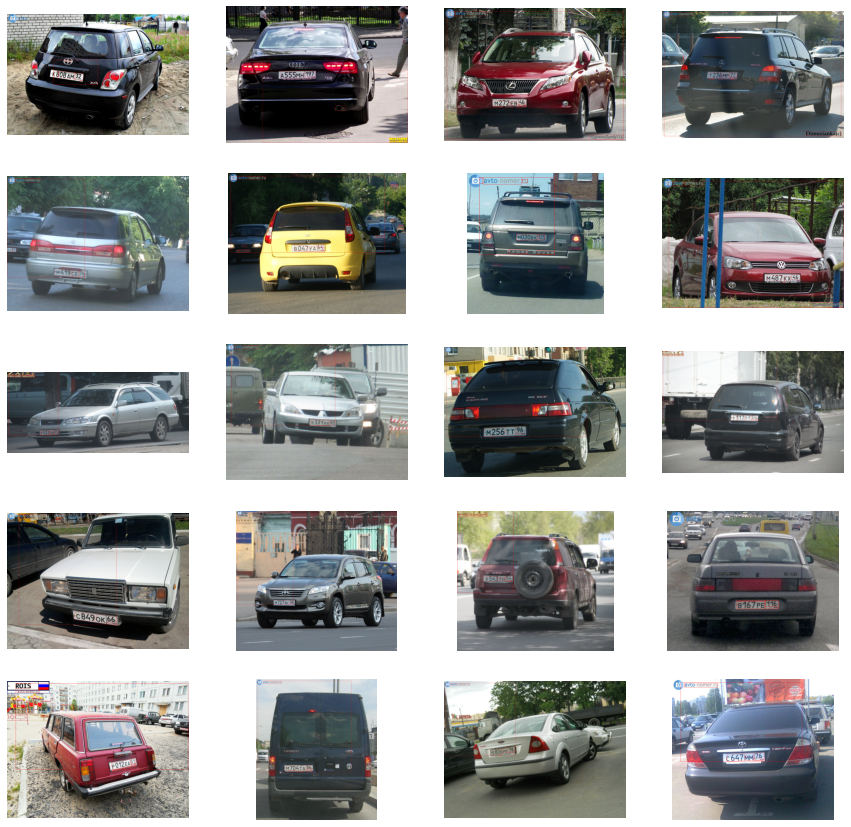

In [17]:
plt.figure(figsize=(15, 15))

for idx, img in enumerate(ocr_img):
    plt.subplot(5, 4, idx+1)
    plt.imshow(img)
    plt.axis('off')

## keras-ocr

In [18]:
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [20]:
images = [keras_ocr.tools.read(im) for im in image_path]
predictions = [pipeline.recognize([im]) for im in image_path]

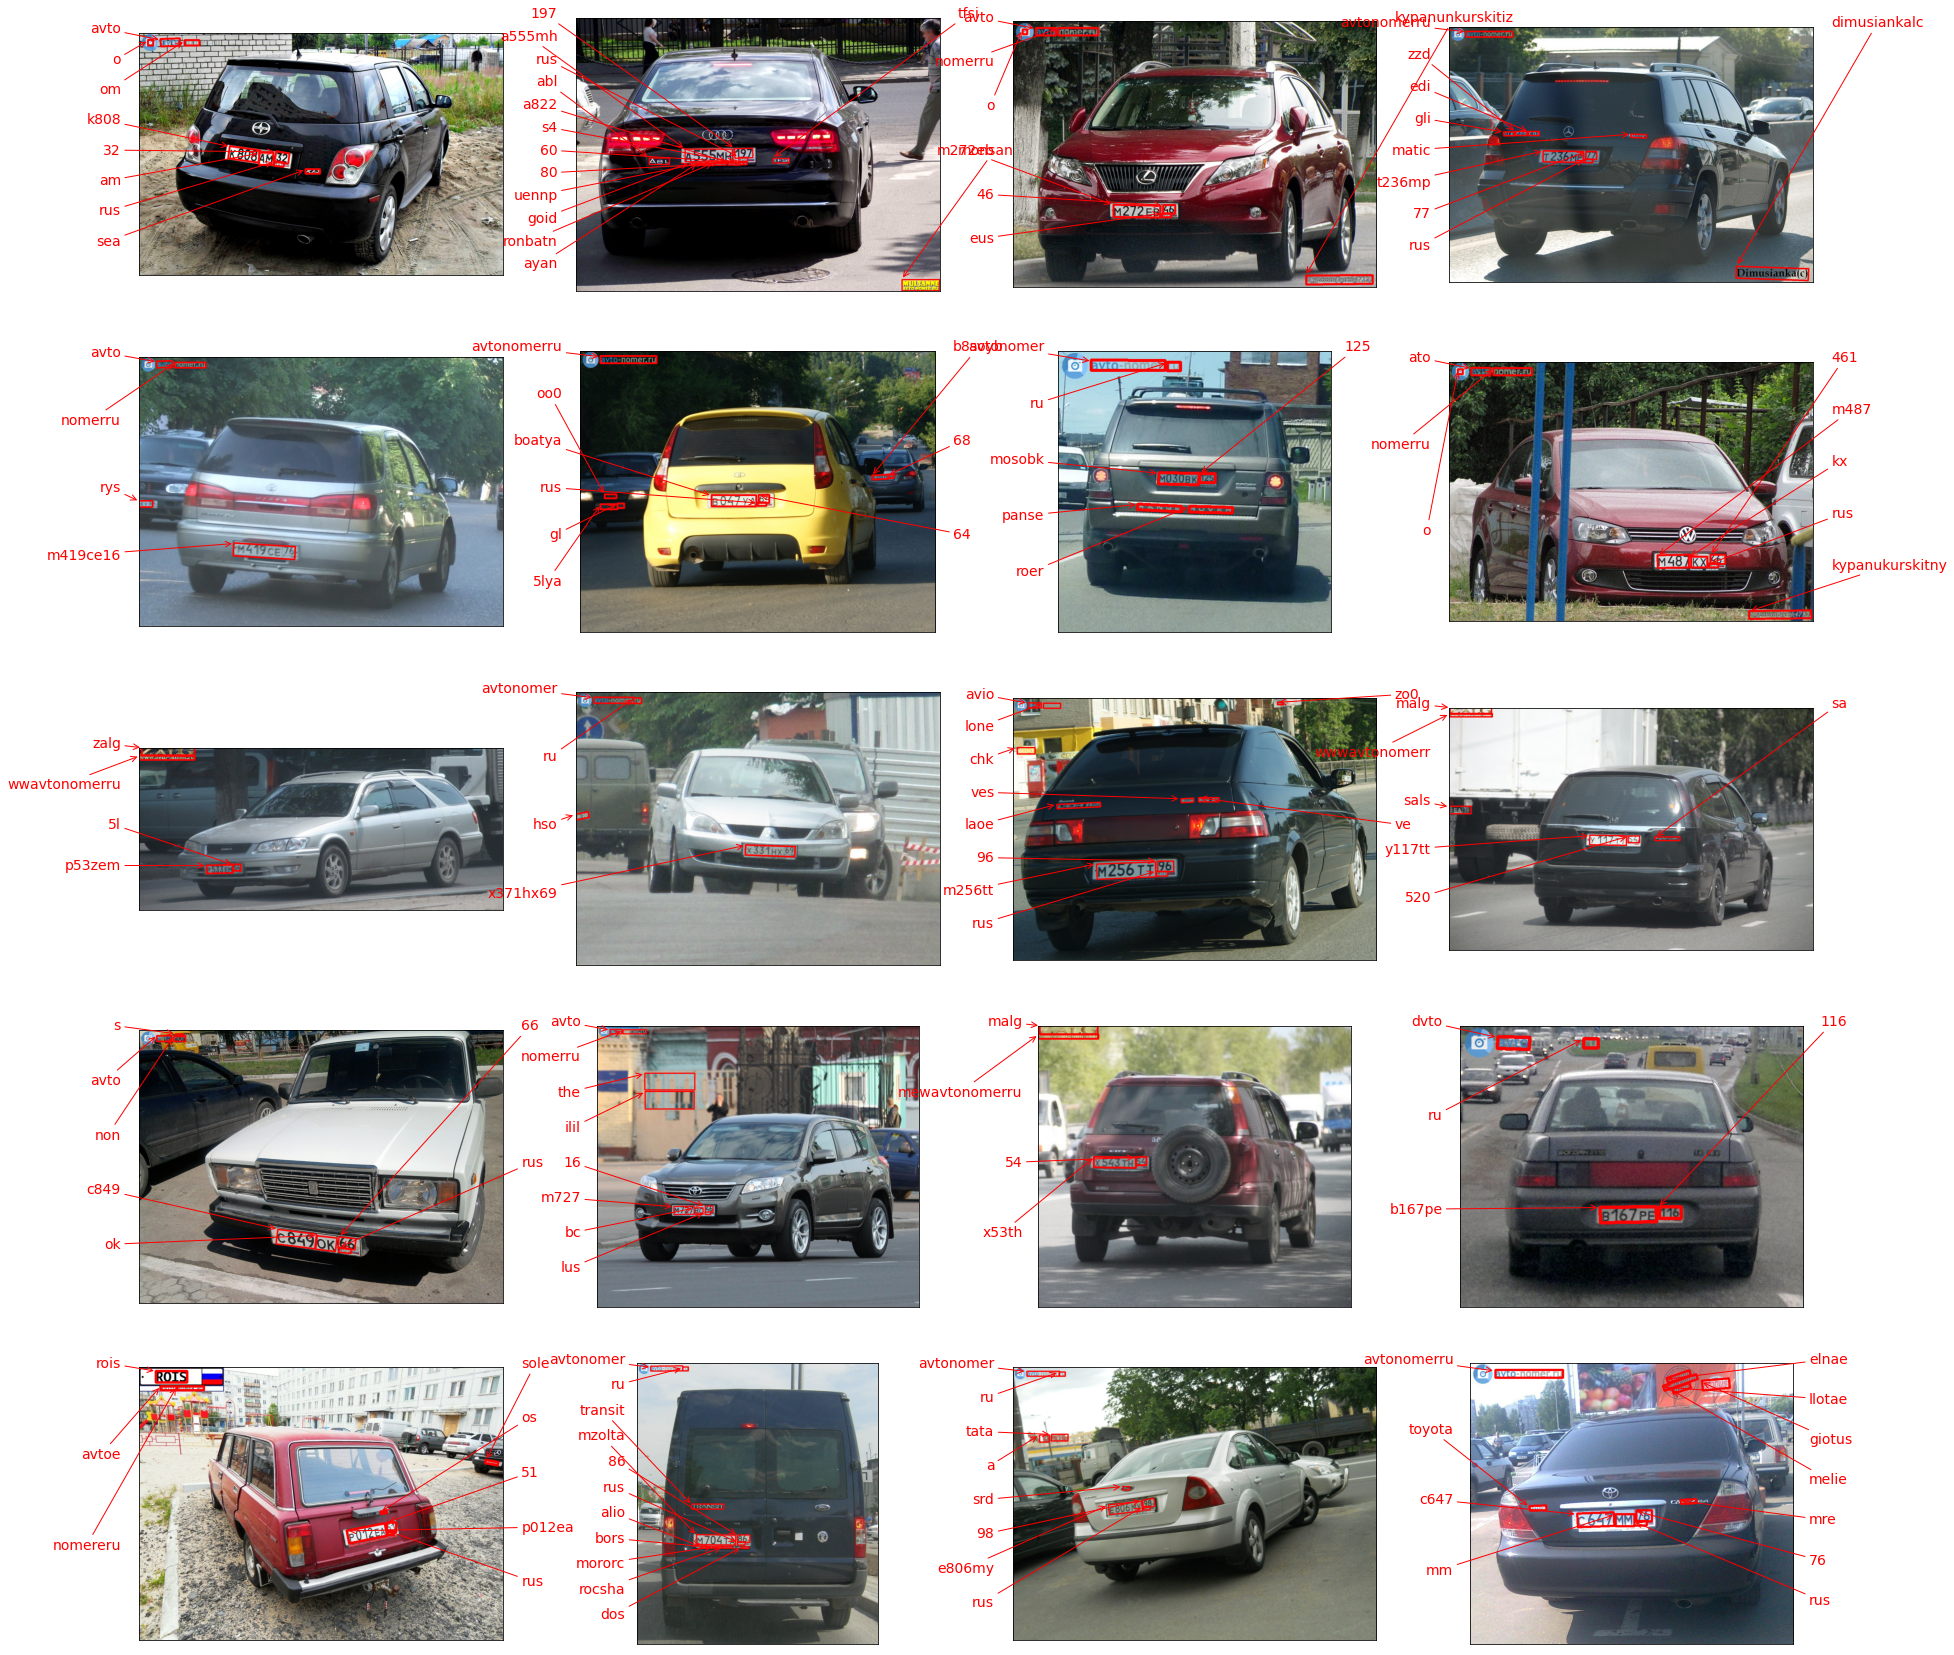

In [21]:
fig, axs = plt.subplots(5, 4, figsize=(30, 30))

for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[4*a+b], 
                                    predictions=predictions[4*a+b][0], ax=axs[a,b])

## Tesseract

In [22]:
def crop_word_regions(image_path, output_path):
    s = os.path.splitext(image_path)
    s = os.path.split(s[0])
    name = s[1]
    output_path = output_path + name +'/'
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 11'
    image = Image.open(image_path)
    img = cv2.imread(image_path)
    
    d = pt.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    top_level = max(d['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(d['level'])):
        level = d['level'][i]
    
        if level == top_level:
            left = d['left'][i]
            top = d['top'][i]
            width = d['width'][i]
            height = d['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return name, cropped_image_path_list, img


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
output_path = work_dir + '/output/'

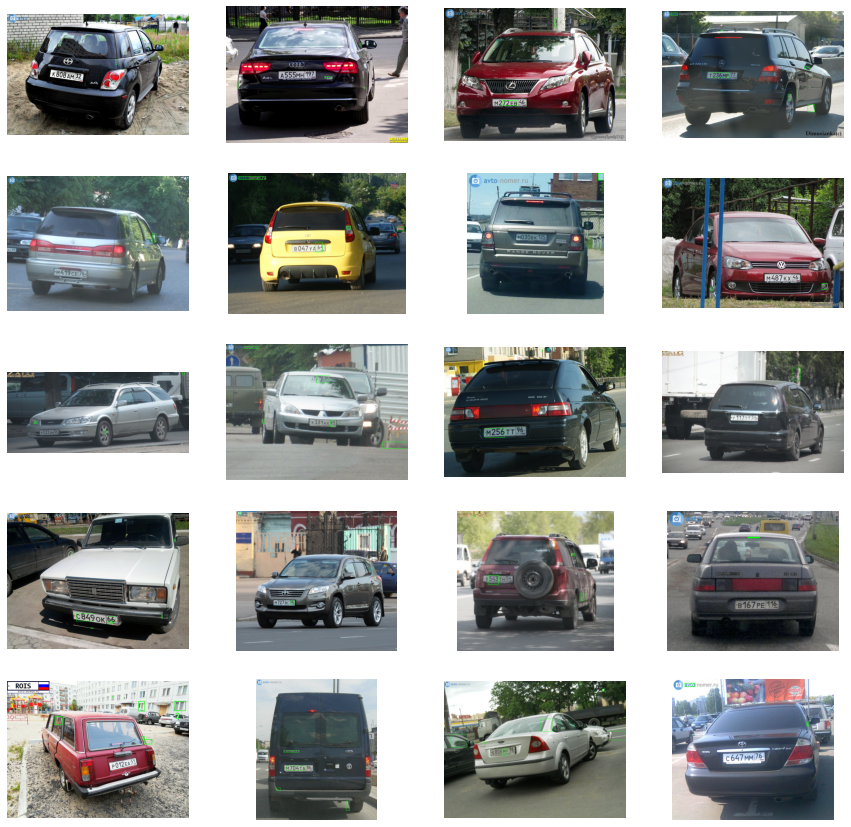

In [25]:
Tesser_dict = {}
img_dict = {}
plt.figure(figsize=(15, 15))

for idx, path in enumerate(image_path):    
    name, cropped_image_path_list, imgs = crop_word_regions(path, output_path)
    Tesser_dict[name] = cropped_image_path_list
    img_dict[name] = imgs
    plt.subplot(5, 4, idx+1)
    plt.imshow(imgs)
    plt.axis('off')

## 비교해보기

In [36]:
def recognize_images(cropped_image_path_list):
    test = []
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pt.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        test.append(recognized_data['text'].replace('\n', '').replace('\x0c',''))
        
    print(test)
    print("Done")

['Oavto-nomer.ruTRANSITFondM704TA 86.RUSOHLIO-HOPK MOTOPC-MOCKBA (s) 737.040s', 'Oavto-nomer.ru', 'TRANSIT', 'Fond', 'M704TA', '86.', 'RUS', 'OHLIO-HOPK', 'MOTOPC-MOCKBA', '(s)', '737.040s']


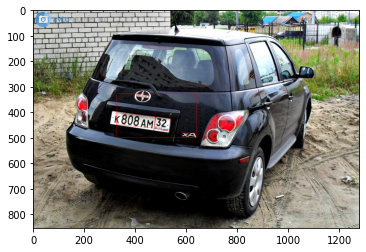

In [27]:
print(ocr_dict['car1'])
plt.imshow(ocr_img[0])

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 7200x7200 with 0 Axes>

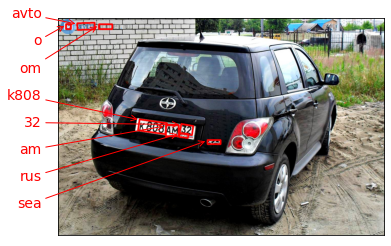

In [34]:
plt.figure(figsize=(100, 100))
a = keras_ocr.tools.drawAnnotations(image=images[0], 
                                    predictions=predictions[0][0])
print(a)

['1 RAINS I TD', '"= tee', 'J At ee', 'ser', 'OFT -MOCKRA W', 'M/O4TA', '=', 'ae i Bt', '', '', 'Op we ge SS en', 'LO el', '', '|', '|', '', 'ie', '']
Done


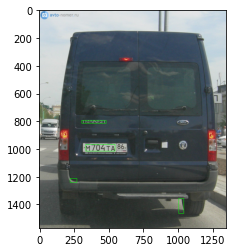

In [43]:
plt.imshow(img_dict['car1'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['car1'])

# 회고

세 가지 OCR 모델을 비교해 본 결과 keras ocr 이 가장 정확도가 높은 것으로 예상된다.  
하지만 Tesseract는 다른 언어도 지원한다고 하니 영어가 아닌 언어를 인식할 때 고려하면 좋을 것이다.  
근데 마지막에 비교할 때 왜 첫 번째 차 사진이 아닌지 조금 이상하다.  
그리고 차 번호판에 있는 문자만 인식해야 하는데 세 모델 모두 다른 배경에 있는 문자까지 인식하고 있다.  
이 부분은 실제 상황에 적용할 때 처리가 필요할 것이라 생각한다.  